In [1]:
!pip install unidecode

In [0]:
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [0]:
# from google.colab import files
# uploaded = files.upload()

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [0]:
# import unidecode
# import string
# import random
# import re

# all_characters = string.printable
# n_characters = len(all_characters)

# file = unidecode.unidecode(open('all_story.txt').read())
# file_len = len(file)
# print('file_len =', file_len)

In [0]:
import random

def read_file(filename): 
  text = open(filename, 'r', encoding = "utf-8-sig").read().splitlines()
  text = " ".join(text)
  return text

import string
import unicodedata

#all_characters = string.ascii_letters + string.punctuation + string.digits + " "
all_characters = string.printable
n_characters = len(all_characters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

In [0]:
file = read_file("all_story.txt")

In [0]:
file = unicodeToAscii(file)
file_len = len(file)

In [8]:
file_len

23456194

To make inputs out of this big string of data, we will be splitting it into chunks.

In [24]:
chunk_len = 1000

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

nd leave him in it; others, that he should be reduced to a state of temporary insensibility, by knocking on the head; others, that he should be sworn to sit where he was until to-morrow at the same hour; others again, that he should be gagged and taken off with them, under a sufficient guard. All these propositions being overruled, it was concluded, at last, to bind him in his chair, and the word was passed for Dennis.  Lookee here, Jack! said Hugh, striding up to him: We are going to tie you, hand and foot, but otherwise you wont be hurt. Dye hear?  John Willet looked at another man, as if he didnt know which was the speaker, and muttered something about an ordinary every Sunday at two oclock.  You wont be hurt I tell you, Jack--do you hear me? roared Hugh, impressing the assurance upon him by means of a heavy blow on the back. Hes so dead scared, hes woolgathering, I think. Give him a drop of something to drink here. Hand over, one of you.  A glass of liquor being passed forward, Hug

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, model ="gru"):
        super(CharRNN, self).__init__()
        self.model = str(model).lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
             
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout = 0.5)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout = 0.5)
        self.decoder = nn.Linear(hidden_size, output_size)

#     def forward(self, input, hidden):
#         batch_size = input.size(0)
#         encoded = self.encoder(input)
#         output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
#         output = self.decoder(output.view(batch_size, -1))
#         return output, hidden

    def forward(self, input, hidden, use_softmax=False):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = output.contiguous().view(batch_size, hidden_size) 
        output = F.dropout(output, 0.5)
        output = self.decoder(output).view(batch_size, -1)
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [28]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if device == "cuda":
        inp = inp.cuda()
        target = target.cuda()
    return inp, target


# **Split Test and Validation**

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=device):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda == "cuda":
      prime_input = prime_input.cuda()
      if isinstance(hidden, tuple):
        hidden = (hidden[0].cuda(), hidden[1].cuda())
      else: 
        hidden = hidden.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if device == "cuda":
      if model == "gru": 
        hidden = hidden.cuda() 
      else:
        hidden = (hidden[0].cuda(), hidden[1].cuda())
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    #return loss.data[0] / chunk_len
    return loss.item() / chunk_len

In [0]:
import os 
def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

Then we define the training parameters, instantiate the model, and start training:

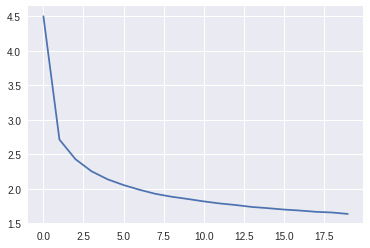

number of epochs completed: 200
========== generated samples ==========
 8s (200 100%) 1.6319]
Whink of the other accontinisuut; and at the Hinge, has not hose of behings, she oust heart of the str 

Saving...
Saved as char-rnn.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
model = 'gru'
n_epochs = 200
hidden_size = 1000
n_layers = 2
learning_rate = 0.005
chunk_len = 200
batch_size = 512

filename = "char-rnn"
print_every = 100
plot_every = 10

decoder = CharRNN(n_characters, hidden_size, n_characters, n_layers, model)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if device == "cuda":
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0


try:
    print("Training for %d epochs..." % n_epochs)
    #for epoch in tqdm(range(1, n_epochs + 1)):
    for epoch in range(1, n_epochs + 1): 
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss

#         if epoch % print_every == 0:
#             print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
#             print(generate(decoder, 'Wh', 100, cuda=device), '\n')
            
        if epoch % plot_every == 0:
          all_losses.append(loss_avg / plot_every)
          loss_avg = 0
          clear_output(wait=True)
          plt.plot(all_losses)
          plt.pause(0.05)
          print("number of epochs completed:", epoch)
          print("========== generated samples ==========")
          print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
          print(generate(decoder, 'Wh', 100, cuda=device), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()
    
if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

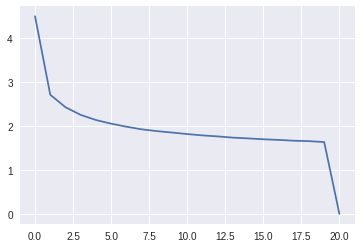

In [35]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [42]:
start = ["a", "b", "c", "d", "e", "f"]
for i in start: 
  print(generate(decoder, i, predict_len=300, temperature=0.5, cuda=device))

and replied the faction and to a present the blight and from him of said of his hand of the old gave should shoute, that the voice of his hands to the deliined the other face in a lintener had not be a neare and dray with the way of partical on one and and winder to him in the little when in a the ha
beer the word of the croad best and recended to the tire.  I though you must said, and heaved to the last part of a look, resideral in a stare of the seared to a tands have been the poor of his fertainer in his laughter to me all the person of the Charces.  The great to the high object to her down in
cart and than having presone of the cather of her looking on the starder in the such a commons alrious in the worth dear to all the did for a roard of a mistration, and starty looked of post on the from the cottable so calling into the door, a man of the complemen of his lead into the course was a gr
din to destrace, and dood it of some of many partice to house and at the lams with a molent fr

Lower temperatures are less varied, choosing only the more probable outputs:

In [39]:
print(generate(decoder, 'T', predict_len=1000, temperature=0.2, cuda=device))

The arm so look of the strange of anything for the severed in a light and short of the doars of the returned with a started of the same of the ofference of his considered in the ward of the present to remark and the Clent dont to the near of a contracted in the same and face of the countense of his should be and a long street to him the suppresses of a state, and all the before the little of the country of the concertion with a preches of a monters of the fires of the course of the dark and some put to the lotter of the fore and far of the letter of the paces of the the into the good of the had all the one of the streat of the state of the come of the sire and congsed the concerning of her face of the sort of the present of the common to same her of her.  The ground of it is the strong some at the concertain of the concertainly was a state of the particular of the consion of the something of its of his fance of the course of a constance, and the sure of the same of the called to the st

Higher temperatures more varied, choosing less probable outputs:

In [38]:
print(generate(decoder, 'Th', predict_len=200, temperature=1.4, cuda=device))

This telreee, whost Pardonbi, creeply was? ited titicle.  Being his liked pauched thant, age.  No nught.  cob ma! readie wirkita,, daks, require To, Nandifme chil agrocivias debo, umall knals-cngard Do,
